In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

1/1 [==============================] - 0s 77ms/step
[[[-0.01104512  0.02993411]
  [-0.00707347 -0.02882335]
  [-0.0008814  -0.00400497]
  [-0.04665482 -0.00796835]
  [-0.01990709  0.04128392]
  [ 0.0398442   0.03063411]
  [ 0.02897508 -0.01199851]
  [-0.0498431  -0.02083453]
  [-0.04607448 -0.03010714]
  [-0.03095071 -0.01496447]]]


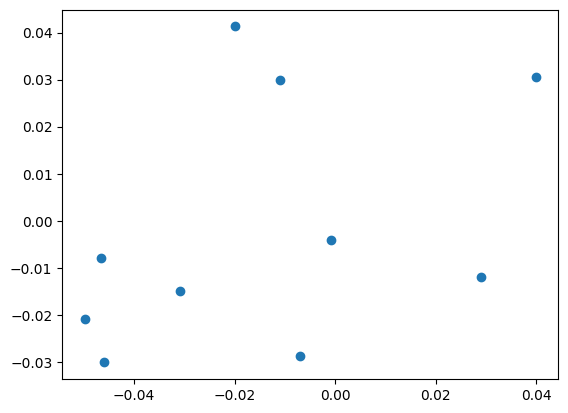

In [2]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than
# 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


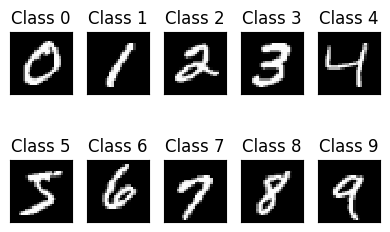

In [4]:
WIDTH_SIZE = 4
HEIGHT_SIZE = 3

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [5]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_train reshape: (60000, 784)


In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

seed_value = 42
initializer = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=seed_value
)


# Generator network
generator = tf.keras.models.Sequential()

# Input layer and hidden layer 1
generator.add(
    tf.keras.layers.Dense(
        128, input_shape=(latent_dim,), kernel_initializer=initializer
    )
)
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(tf.keras.layers.Dense(256))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(tf.keras.layers.Dense(512))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.BatchNormalization(momentum=0.8))

# Output layer
generator.add(tf.keras.layers.Dense(img_dim, activation="tanh"))

In [7]:
# prints a summary representation of your model
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [8]:
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = tf.keras.layers.Input(shape=(1,), dtype='int32')
label_embedding = tf.keras.layers.Embedding(num_classes, latent_dim)(label)
label_embedding = tf.keras.layers.Flatten()(label_embedding)

# latent space
z = tf.keras.layers.Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = tf.keras.layers.multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = tf.keras.models.Model([z, label], img)

In [9]:
# prints a summary representation of your model
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               1000      ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten (Flatten)           (None, 100)                  0         ['embedding_1[0][0]']         
                                                                                              

In [10]:
# Discriminator network
discriminator = tf.keras.models.Sequential()

# Input layer and hidden layer 1
discriminator.add(
    tf.keras.layers.Dense(
        128, input_shape=(img_dim,), kernel_initializer=initializer
    )
)
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(tf.keras.layers.Dense(256))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(tf.keras.layers.Dense(512))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [11]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [12]:
# Embedding condition in input layer

# Create label embeddings
label_d = tf.keras.layers.Input(shape=(1,), dtype='int32')
label_embedding_d = tf.keras.layers.Embedding(num_classes, img_dim)(label_d)
label_embedding_d = tf.keras.layers.Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = tf.keras.layers.Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = tf.keras.layers.multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = tf.keras.models.Model([img_d, label_d], validity)

In [13]:
# prints a summary representation of your model
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 784)               7840      ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 784)                  0         ['embedding_2[0][0]']         
                                                                                            

In [14]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

In [19]:
discriminator.trainable = False

# Assuming 'latent_dim' is the dimension of your latent space
z = tf.keras.layers.Input(shape=(latent_dim,))

validity = discriminator([generator([z, label]), label])

d_g = tf.keras.models.Model([z, label], validity)

# Create a new optimizer instance for d_g
d_g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

d_g.compile(
    optimizer=d_g_optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

In [20]:
# prints a summary representation of your model
d_g.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 model (Functional)          (None, 784)                  584312    ['input_5[0][0]',             
                                                                     'input_1[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 1)                    273441    ['model[2][0]',         

epoch = 1/100, d_loss=0.602, g_loss=1.204                                                                                                     
1/1 [==============================] - 0s 107ms/step


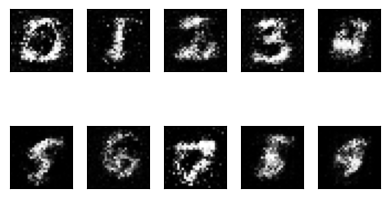

epoch = 2/100, d_loss=0.683, g_loss=0.964                                                                                                     
epoch = 3/100, d_loss=0.679, g_loss=0.868                                                                                                     
epoch = 4/100, d_loss=0.678, g_loss=0.794                                                                                                     
epoch = 5/100, d_loss=0.677, g_loss=0.830                                                                                                     
epoch = 6/100, d_loss=0.686, g_loss=0.812                                                                                                     
epoch = 7/100, d_loss=0.674, g_loss=0.796                                                                                                     
epoch = 8/100, d_loss=0.682, g_loss=0.810                                                                                                     

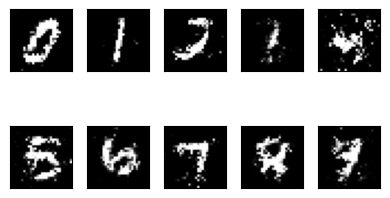

epoch = 12/100, d_loss=0.686, g_loss=0.782                                                                                                     
epoch = 13/100, d_loss=0.672, g_loss=0.860                                                                                                     
epoch = 14/100, d_loss=0.645, g_loss=0.835                                                                                                     
epoch = 15/100, d_loss=0.665, g_loss=0.922                                                                                                     
epoch = 16/100, d_loss=0.657, g_loss=0.907                                                                                                     
epoch = 17/100, d_loss=0.650, g_loss=0.897                                                                                                     
epoch = 18/100, d_loss=0.654, g_loss=0.921                                                                                              

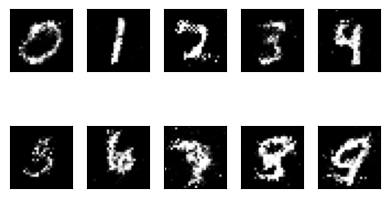

epoch = 22/100, d_loss=0.656, g_loss=0.863                                                                                                     
epoch = 23/100, d_loss=0.660, g_loss=0.887                                                                                                     
epoch = 24/100, d_loss=0.667, g_loss=0.844                                                                                                     
epoch = 25/100, d_loss=0.680, g_loss=0.833                                                                                                     
epoch = 26/100, d_loss=0.644, g_loss=0.858                                                                                                     
epoch = 27/100, d_loss=0.672, g_loss=0.899                                                                                                     
epoch = 28/100, d_loss=0.652, g_loss=0.883                                                                                              

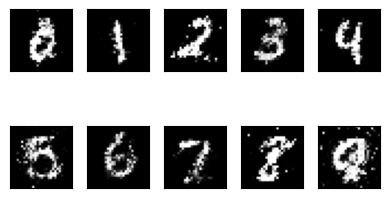

epoch = 32/100, d_loss=0.653, g_loss=0.840                                                                                                     
epoch = 33/100, d_loss=0.685, g_loss=0.878                                                                                                     
epoch = 34/100, d_loss=0.664, g_loss=0.888                                                                                                     
epoch = 35/100, d_loss=0.663, g_loss=0.898                                                                                                     
epoch = 36/100, d_loss=0.658, g_loss=0.840                                                                                                     
epoch = 37/100, d_loss=0.649, g_loss=0.874                                                                                                     
epoch = 38/100, d_loss=0.635, g_loss=0.908                                                                                              

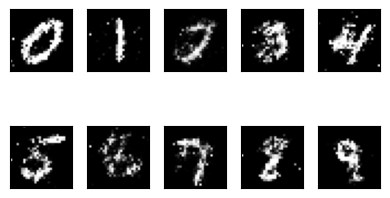

epoch = 42/100, d_loss=0.684, g_loss=0.871                                                                                                     
epoch = 43/100, d_loss=0.648, g_loss=0.843                                                                                                     
epoch = 44/100, d_loss=0.660, g_loss=0.890                                                                                                     
epoch = 45/100, d_loss=0.658, g_loss=0.840                                                                                                     
epoch = 46/100, d_loss=0.662, g_loss=0.913                                                                                                     
epoch = 47/100, d_loss=0.661, g_loss=0.832                                                                                                     
epoch = 48/100, d_loss=0.648, g_loss=0.895                                                                                              

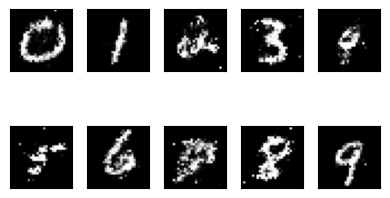

epoch = 52/100, d_loss=0.639, g_loss=0.914                                                                                                     
epoch = 53/100, d_loss=0.671, g_loss=0.875                                                                                                     
epoch = 54/100, d_loss=0.664, g_loss=0.888                                                                                                     
epoch = 55/100, d_loss=0.657, g_loss=0.878                                                                                                     
epoch = 56/100, d_loss=0.668, g_loss=0.935                                                                                                     
epoch = 57/100, d_loss=0.647, g_loss=0.884                                                                                                     
epoch = 58/100, d_loss=0.693, g_loss=0.891                                                                                              

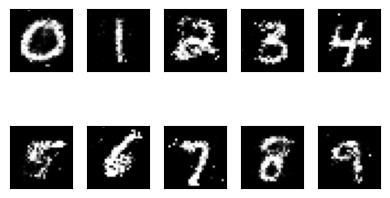

epoch = 62/100, d_loss=0.671, g_loss=0.887                                                                                                     
epoch = 63/100, d_loss=0.685, g_loss=0.841                                                                                                     
epoch = 64/100, d_loss=0.633, g_loss=0.876                                                                                                     
epoch = 65/100, d_loss=0.644, g_loss=0.901                                                                                                     
epoch = 66/100, d_loss=0.662, g_loss=0.919                                                                                                     
epoch = 67/100, d_loss=0.651, g_loss=0.852                                                                                                     
epoch = 68/100, d_loss=0.644, g_loss=0.898                                                                                              

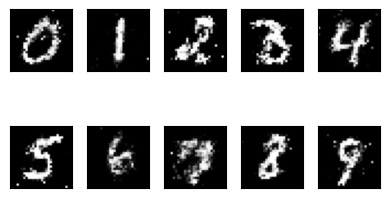

epoch = 72/100, d_loss=0.633, g_loss=0.878                                                                                                     
epoch = 73/100, d_loss=0.647, g_loss=0.846                                                                                                     
epoch = 74/100, d_loss=0.673, g_loss=0.860                                                                                                     
epoch = 75/100, d_loss=0.672, g_loss=0.906                                                                                                     
epoch = 76/100, d_loss=0.654, g_loss=0.859                                                                                                     
epoch = 77/100, d_loss=0.660, g_loss=0.895                                                                                                     
epoch = 78/100, d_loss=0.655, g_loss=0.846                                                                                              

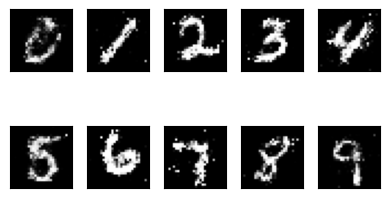

epoch = 82/100, d_loss=0.666, g_loss=0.885                                                                                                     
epoch = 83/100, d_loss=0.652, g_loss=0.868                                                                                                     
epoch = 84/100, d_loss=0.638, g_loss=0.839                                                                                                     
epoch = 85/100, d_loss=0.679, g_loss=0.885                                                                                                     
epoch = 86/100, d_loss=0.659, g_loss=0.909                                                                                                     
epoch = 87/100, d_loss=0.658, g_loss=0.829                                                                                                     
epoch = 88/100, d_loss=0.655, g_loss=0.872                                                                                              

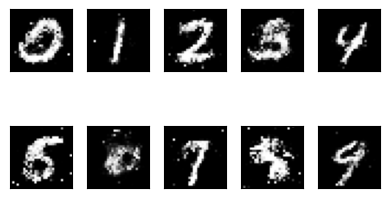

epoch = 92/100, d_loss=0.641, g_loss=0.891                                                                                                     
epoch = 93/100, d_loss=0.677, g_loss=0.916                                                                                                     
epoch = 94/100, d_loss=0.633, g_loss=0.900                                                                                                     
epoch = 95/100, d_loss=0.649, g_loss=0.900                                                                                                     
epoch = 96/100, d_loss=0.663, g_loss=0.916                                                                                                     
epoch = 97/100, d_loss=0.660, g_loss=0.860                                                                                                     
epoch = 98/100, d_loss=0.651, g_loss=0.845                                                                                              

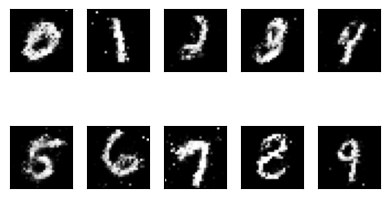

In [21]:
epochs = 100
batch_size = 64
smooth = 0.1

real = tf.ones(shape=(batch_size, 1))
fake = tf.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        real_labels = y_train[i * batch_size : (i + 1) * batch_size].reshape(
            -1, 1
        )

        d_loss_real = discriminator.train_on_batch(
            x=[X_batch, real_labels], y=real * (1 - smooth)
        )

        # Fake Samples
        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])

        d_loss_fake = discriminator.train_on_batch(
            x=[X_fake, random_labels], y=fake
        )

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                d_g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])

    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], d_g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10
        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        labels = np.arange(0, 10).reshape(-1, 1)

        x_fake = generator.predict([z, labels])

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap="gray")
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()